In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [29]:
data = pd.read_csv('../../data/final/final.csv', index_col='year', parse_dates=True)
neighbourhoods = data['Neighbourhood'].unique()

In [46]:
df = data.loc[data['Neighbourhood'] == neighbourhoods[1]]['livability_score'].to_frame()

In [48]:
df

,livability_score
year,
2014-01-01,42.386274
2015-01-01,40.808704
2016-01-01,39.194789
2017-01-01,43.575087
2018-01-01,40.836322
2019-01-01,43.509325
2020-01-01,39.016633


<AxesSubplot: xlabel='year'>

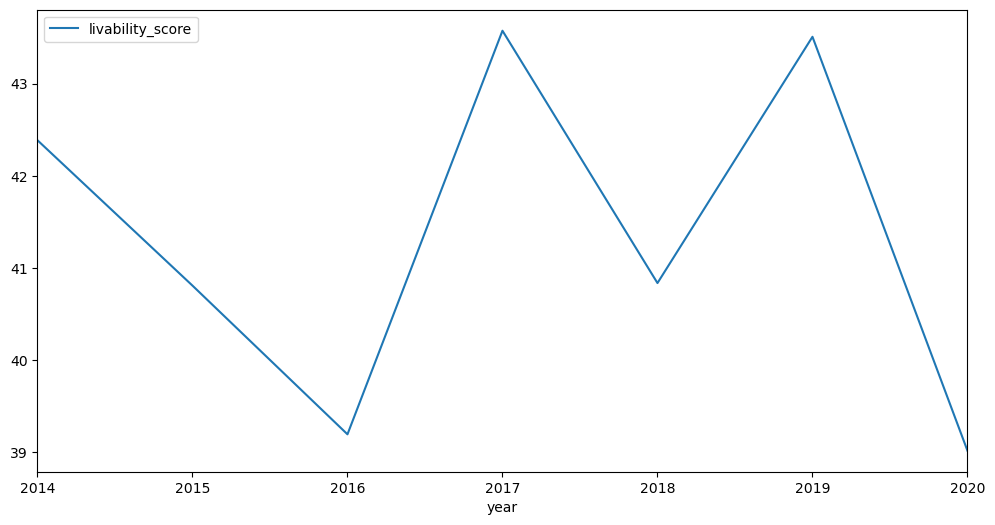

In [49]:
df.plot(figsize=(12, 6))

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose

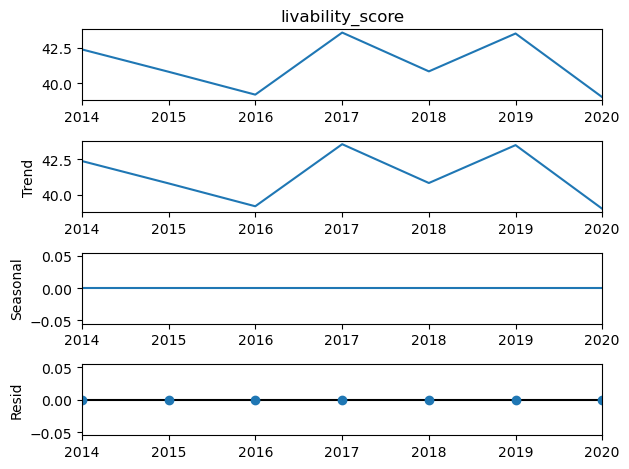

In [51]:
results = seasonal_decompose(df['livability_score'])
results.plot();

In [52]:
len(df)

7

In [53]:
train = df.iloc[:5]
test = df.iloc[2:]

In [54]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [55]:
df.head(), df.tail()

(            livability_score
 year                        
 2014-01-01         42.386274
 2015-01-01         40.808704
 2016-01-01         39.194789
 2017-01-01         43.575087
 2018-01-01         40.836322,
             livability_score
 year                        
 2016-01-01         39.194789
 2017-01-01         43.575087
 2018-01-01         40.836322
 2019-01-01         43.509325
 2020-01-01         39.016633)

In [56]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [57]:
scaled_train[:10]

array([[0.72859989],
       [0.36844866],
       [0.        ],
       [1.        ],
       [0.37475365]])

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
X, y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [ ]:
X.shape

(1, 3, 1)

In [ ]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
model.fit(generator, epochs=50)

Epoch 1/50
144/144 [==============================] - 2s 5ms/step - loss: 0.0784
Epoch 2/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0248
Epoch 3/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0169
Epoch 4/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0134
Epoch 5/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0128
Epoch 6/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0073
Epoch 7/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0053
Epoch 8/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0056
Epoch 9/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0047
Epoch 10/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0040
Epoch 11/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0034
Epoch 12/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0035
Epoch 13/50
144/144 [====

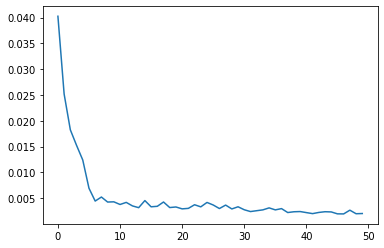

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [ ]:
last_train_batch = scaled_train[-12:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(last_train_batch)

array([[0.6046513]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.67548077])

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [ ]:
test_predictions

[array([0.6046513], dtype=float32),
 array([0.5854211], dtype=float32),
 array([0.7456695], dtype=float32),
 array([0.8121553], dtype=float32),
 array([0.911981], dtype=float32),
 array([0.8914289], dtype=float32),
 array([0.8224216], dtype=float32),
 array([0.7289473], dtype=float32),
 array([0.6303051], dtype=float32),
 array([0.59199744], dtype=float32),
 array([0.54971915], dtype=float32),
 array([0.5722453], dtype=float32)]

In [ ]:
test.head()

,Production,Predictions
Date,,
1975-01-01,834,813.303572
1975-02-01,782,809.682804
1975-03-01,892,879.037941
1975-04-01,903,912.407272
1975-05-01,966,954.157072


In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions

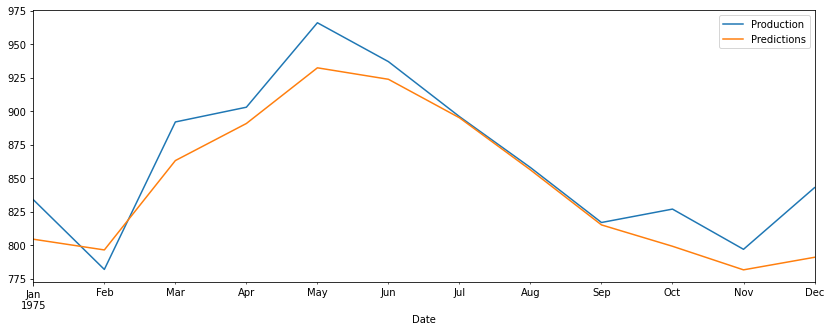

In [ ]:
test.plot(figsize=(14, 5))

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test['Production'], test['Predictions']))
print(rmse)

24.270639050894633
